In [69]:
%reload_ext autoreload
%autoreload 2


I changed this to include the author information, because we need it later

In [69]:
import pandas as pd

# the name and location of the article records for the IM journal (in CSV format)
records_file = '../data/main-review-article-records.csv'

columns = ['article_author',
           'article_author_index_name', 
           'article_title', 
           'issue_pub_year', 
           'publisher', 
           'article_type']
# load the csv data into a data frame
df = pd.read_csv(records_file, usecols=columns)
# show the first and last records of the dataset to demonstrate what the records look like
df.head(5)

,article_title,article_author,article_author_index_name,issue_pub_year,publisher,article_type
0,The importance of emigration for the solution ...,"Wander, H.","Wander, H.",1951,Staatsdrukkerij,main
1,European emigration overseas past and future,"Citroen, H.A.","Citroen, H.A.",1951,Staatsdrukkerij,main
2,Some aspects of migration problems in the Neth...,"Beijer, G. && Oudegeest, J.J.","Beijer, G. && Oudegeest, J.J.",1952,Staatsdrukkerij,main
3,Some quantitative aspects of future population...,"Brink, van den, T.","Brink, van den, T.",1952,Staatsdrukkerij,main
4,"The refugees as a burden, a stimulus, and a ch...","Edding, F.","Edding, F.",1951,Staatsdrukkerij,main


In [75]:
len(df.loc[df.article_author.isna()])
# we change nan's to ''
df.article_author_index_name.fillna('', inplace=True)

In [107]:
def parse_surname(author_name: str):
    return author_name.split(',')[0].replace('ij', 'y').title()


def parse_surname_initial(author_name: str):
    if ',' not in author_name:
        return author_name
    surname = author_name.split(',')[0].replace('ij', 'y').title()
    initial = author_name.split(', ')[1][0]
    return f'{surname}, {initial}'


df['article_author_index_name'] = df['article_author_index_name'].str.title()
df['author_surname_initial'] = df.article_author_index_name.apply(parse_surname_initial)
df['issue_pub_decade'] = df.issue_pub_year.apply(lambda x: int(x/10)*10)

df

,article_title,article_author,article_author_index_name,issue_pub_year,publisher,article_type,author_surname_initial,issue_pub_decade,dataset,issue_decade,...,decision making,labour,skill,legal,forced,immigration,emigration,migration,group,identity
0,The importance of emigration for the solution ...,"Wander, H.","Wander, H.",1951,Staatsdrukkerij,main,"Wander, H",1950,REMP_IM,1950,...,0,0,0,0,0,0,1,0,0,0
1,European emigration overseas past and future,"Citroen, H.A.","Citroen, H.A.",1951,Staatsdrukkerij,main,"Citroen, H",1950,REMP_IM,1950,...,0,0,0,0,0,0,1,0,0,0
2,Some aspects of migration problems in the Neth...,"Beijer, G. && Oudegeest, J.J.","Beijer, G. && Oudegeest, J.J.",1952,Staatsdrukkerij,main,"Beyer, G",1950,REMP_IM,1950,...,0,0,0,0,0,0,0,0,0,0
3,Some quantitative aspects of future population...,"Brink, van den, T.","Brink, Van Den, T.",1952,Staatsdrukkerij,main,"Brink, V",1950,REMP_IM,1950,...,0,0,0,0,0,0,0,0,0,0
4,"The refugees as a burden, a stimulus, and a ch...","Edding, F.","Edding, F.",1951,Staatsdrukkerij,main,"Edding, F",1950,REMP_IM,1950,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4279,Chapter Four: Going North,NaN,,1986,Sage Publishing,main,,1980,IMR_research,1980,...,0,0,0,0,0,0,0,0,0,0
4280,Chapter Five: The New York Labor Market,NaN,,1986,Sage Publishing,main,,1980,IMR_research,1980,...,0,1,0,0,0,0,0,0,0,0
4281,Chapter Six: The Settlement Process,NaN,,1986,Sage Publishing,main,,1980,IMR_research,1980,...,0,0,0,0,0,0,0,0,0,0
4282,Chapter Seven: Conclusion,NaN,,1986,Sage Publishing,main,,1980,IMR_research,1980,...,0,0,0,0,0,0,0,0,0,0


In [144]:
len(df.loc[df.author_surname_initial == ''])

448

In [112]:
def map_dataset(publisher, article_type):
    # all REMP and IM (published by Wiley) articles are bunlded in a single dataset
    if publisher == 'Staatsdrukkerij' or publisher == 'Wiley':
        return 'REMP_IM'
    # The IMR articles are separated in review articles and research articles
    return 'IMR_research' if article_type == 'main' else 'IMR_review'

df['dataset'] = df.apply(lambda x: map_dataset(x['publisher'], x['article_type']), axis=1)
df.dataset.value_counts()

IMR_review      1842
IMR_research    1539
REMP_IM          903
Name: dataset, dtype: int64

In [113]:
# adding a column per article with the publication decade
df['issue_decade'] = df.issue_pub_year.apply(lambda x: int(x/10) * 10 if not pd.isnull(x) else x)

df.issue_decade.value_counts()

1990    1490
1980    1236
1970    1052
1960     404
1950     102
Name: issue_decade, dtype: int64

In [114]:
import scripts.content_analysis as ca

# create a normalised version of the article title
# - remove footnote symbols, stopwords, punctuation and quote characters
# - standardise acronyms
# - remove 'Book Review: ' prefix from review article titles
df['normalised_title'] = df.article_title.apply(ca.normalise_title)
df.normalised_title

0       the importance of emigration for the solution ...
1            european emigration overseas past and future
2       some aspect of migration problem in the nether...
3       some quantitative aspect of future population ...
4       the refugee as a burden a stimulus and a chall...
                              ...                        
4279                                chapter four go north
4280               chapter five the new york labor market
4281                   chapter six the settlement process
4282                             chapter seven conclusion
4283                                         bibliography
Name: normalised_title, Length: 4284, dtype: object

In [115]:
from collections import defaultdict
bigram_freq = ca.get_bigram_freq(list(df.normalised_title), remove_stop=True)

endings = ['migration', 'immigration', 'emigration']
ending_bigrams = defaultdict(list)

for bigram, freq in bigram_freq.most_common(10000):
    for ending in endings:
        if bigram.endswith(f' {ending}'):
            ending_bigrams[ending].append((bigram, freq))
            
for ending in endings:
    for bigram, freq in ending_bigrams[ending]:
        print(bigram, freq)

international migration 115
return migration 40
labor migration 33
internal migration 32
labour migration 22
european migration 9
south-north migration 8
mexican migration 7
east-west migration 6
undocumented migration 6
overseas migration 5
human migration 5
rural-urban migration 5
urban migration 5
indian migration 5
force migration 4
italian migration 4
selective migration 3
post-war migration 3
economic migration 3
new migration 3
mass migration 3
family migration 3
chain migration 3
irregular migration 3
illegal migration 3
philippine migration 3
woman migration 3
recent migration 3
modern migration 2
external migration 2
plan migration 2
community migration 2
chinese migration 2
manpower migration 2
group migration 2
migration migration 2
quiet migration 2
net migration 2
circular migration 2
north migration 2
change migration 2
rural migration 2
female migration 2
rican migration 2
population migration 2
black migration 2
canadian migration 2
nonreturn migration 2
us migration 2

In [116]:
from collections import Counter, defaultdict

from scripts.countries import CountryLookup

lookup = CountryLookup()

ending_freq = defaultdict(Counter)

for ending in endings:
    for bigram, freq in ending_bigrams[ending]:
        countries, continents = lookup.extract_countries_continents(bigram, include_nationalities=True)
        #print(bigram, freq, countries, continents)
        ending_freq[ending].update(countries + continents)
        
for ending in ending_freq:
    for region, freq in ending_freq[ending].most_common(10):
        print(ending, region, freq)

migration Europe 10
migration Asia 9
migration North America 5
migration Philippines 2
migration Australia 2
migration Oceania 2
migration South America 2
migration Africa 2
migration Mexico 1
migration India 1
immigration Europe 9
immigration Asia 8
immigration North America 5
immigration Africa 3
immigration Canada 2
immigration Australia 2
immigration Oceania 2
immigration South America 2
immigration Mexico 2
immigration Germany 2
emigration Europe 13
emigration North America 4
emigration Asia 3
emigration South America 2
emigration Italy 1
emigration Spain 1
emigration Netherlands 1
emigration Ireland 1
emigration United Kingdom 1
emigration Malta 1


In [204]:
topic_lists = """
- cause_effect: cause, causal, determinant, factor, influen, setting, effect, affect, impact, consequence, implication
- process: process, dynamic, rate, development, pattern, change, changing, interact, relation, evolution, transform, interpretation, participat
- decision making: policy, policies, politic, decision, management, managing, govern, promotion, planned, recruitment, law, act, implement, amend, guidelines, reform, program, enforcement, legislation, legislative, control, refine, revis, border, international, national, protection, coordination, rationale, administrat, examinat
- labour: labour, labor, worker, work, employment, occupation,
- skill: low-skill, skilled, skill, high-level, professional, intellectual, scientist, brain drain, vocational, vocational training
- legal: illegal, legal, undocumented, unwanted, undesirable, citizenship, right
- forced: involuntary, forced, refuge, refugee, necessity, war, conflict, asylum
- immigration: immigrant, immigrate, immigration
- emigration: emigrant, emigrate, emigration, overseas destination, voluntary return
- migration: migratory, migrant, migración, migrantes, migratoria, migraciones, migraci, arbeitsmigranten, migratori, migrazioni, migratoire, migrações
- group: family, household, community, group
- identity: identity, nationality, nationalism, xenophob, ethnic, race, ideolog, naturali, assimilation, integration, adaptation , absorption
"""

extra = """
- outcome: failure, disenchantment, success, advantage, disadvantage, positive, negative
- business: business, entrep, production, market, industr
- education: education, school, learn
- health: health, medic, disease, epidem
- gender: male, female, gender, women
"""

def make_topics(topic_lists):
    topic_lists = [topic_list[2:] for topic_list in topic_lists.split('\n') if topic_list != '']
    topic_words = {tl.split(': ')[0]: tl.split(': ')[1].split(', ') for tl in topic_lists}
    return topic_words

discipline_lists = """
- psychology: psycholog
- economics: economic, trade
- statistics: statist
- sociology: sociology, social, socio-economic, anthropology, culture
- demography: demography, demographic
"""
discipline_words = make_topics(discipline_lists)

topic_words = make_topics(topic_lists)
topic_words

{'cause_effect': ['cause',
  'causal',
  'determinant',
  'factor',
  'influen',
  'setting',
  'effect',
  'affect',
  'impact',
  'consequence',
  'implication'],
 'process': ['process',
  'dynamic',
  'rate',
  'development',
  'pattern',
  'change',
  'changing',
  'interact',
  'relation',
  'evolution',
  'transform',
  'interpretation',
  'participat'],
 'decision making': ['policy',
  'policies',
  'politic',
  'decision',
  'management',
  'managing',
  'govern',
  'promotion',
  'planned',
  'recruitment',
  'law',
  'act',
  'implement',
  'amend',
  'guidelines',
  'reform',
  'program',
  'enforcement',
  'legislation',
  'legislative',
  'control',
  'refine',
  'revis',
  'border',
  'international',
  'national',
  'protection',
  'coordination',
  'rationale',
  'administrat',
  'examinat'],
 'labour': ['labour', 'labor', 'worker', 'work', 'employment', 'occupation,'],
 'skill': ['low-skill',
  'skilled',
  'skill',
  'high-level',
  'professional',
  'intellectual',
 

First we add the groups to the dataframe and then look for some combinations

In [118]:
for k in topic_words.keys():
    df[k] = df.article_title.apply(lambda x: has_topic(x, topic_words[k]))

In [119]:
for k in topic_words.keys():
    print(k, len(df.loc[(df[k]==1)]))

cause_effect 241
process 416
decision making 806
labour 405
skill 77
legal 149
forced 331
immigration 828
emigration 149
migration 265
group 219
identity 522


In [120]:
for mt in ['emigration','immigration', 'migration']:
    lmt = len(df.loc[(df[mt]==1)])
    for k in topic_words.keys():
        if k != mt:
            print(mt, k, round(len(df.loc[(df[mt]==1) & (df[k]==1)])/lmt * 100,2))
    print('-------')

emigration cause_effect 11.41
emigration process 18.12
emigration decision making 11.41
emigration labour 6.04
emigration skill 4.7
emigration legal 2.01
emigration forced 4.03
emigration immigration 3.36
emigration migration 1.34
emigration group 0.0
emigration identity 2.01
-------
immigration cause_effect 6.52
immigration process 10.87
immigration decision making 18.72
immigration labour 10.39
immigration skill 2.17
immigration legal 5.19
immigration forced 3.14
immigration emigration 0.6
immigration migration 0.97
immigration group 6.4
immigration identity 16.06
-------
migration cause_effect 6.79
migration process 8.3
migration decision making 19.25
migration labour 28.3
migration skill 2.26
migration legal 10.19
migration forced 4.15
migration immigration 3.02
migration emigration 0.75
migration group 4.91
migration identity 5.66
-------


In [251]:
lookup = CountryLookup()

ending_freq = defaultdict(Counter)

# for ending in endings:
#     for bigram, freq in ending_bigrams[ending]:
#         countries, continents = lookup.extract_countries_continents(bigram, include_nationalities=True)
#         #print(bigram, freq, countries, continents)
#         ending_freq[ending].update(countries + continents)
        
# for ending in ending_freq:
#     for region, freq in ending_freq[ending].most_common(10):
#         print(ending, region, freq)
def extract_country(x):
    c = lookup.extract_countries_continents(x)[0]
    if len(c)>0:
        return(c[0])
        
df['country']=df.normalised_title.apply(extract_country)

In [252]:
def extract_continent(x):
    c = lookup.extract_countries_continents(x)[1]
    if len(c)>0:
        return(c[0])
df['continent']=df.normalised_title.apply(extract_continent)

In [253]:
df.columns

Index(['article_title', 'article_author', 'article_author_index_name',
       'issue_pub_year', 'publisher', 'article_type', 'author_surname_initial',
       'issue_pub_decade', 'dataset', 'issue_decade', 'normalised_title',
       'cause_effect', 'process', 'decision making', 'labour', 'skill',
       'legal', 'forced', 'immigration', 'emigration', 'migration', 'group',
       'identity', 'country', 'continent'],
      dtype='object')

In [122]:
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer, CountVectorizer

stopwords = ca.get_stopwords()


# make a list of all the titles with identified bigrams.
docs = list(df.article_title)

# instantiate a CountVectorizer() 
cv=CountVectorizer(stop_words=stopwords, analyzer='word') 
 
# compute word counts per title
word_count_vector=cv.fit_transform(docs)
# instantiate a tf*idf transformer
tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True) 
# fit the word counts per title to the tf*idf transformer
tfidf_transformer.fit(word_count_vector)


# extract the IDF values 
df_idf = pd.DataFrame(tfidf_transformer.idf_, index=cv.get_feature_names(),columns=["idf_weights"]) 
 
# show the term with lowest and highest IDF scores
df_idf.sort_values(by=['idf_weights'])

,idf_weights
review,1.817486
book,1.820662
migration,2.636642
immigration,3.487945
immigrants,3.626304
...,...
grèce,8.669729
gründung,8.669729
guanella,8.669729
grey,8.669729


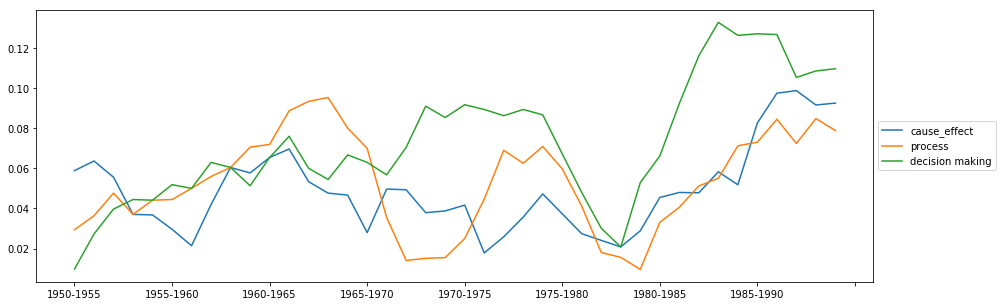

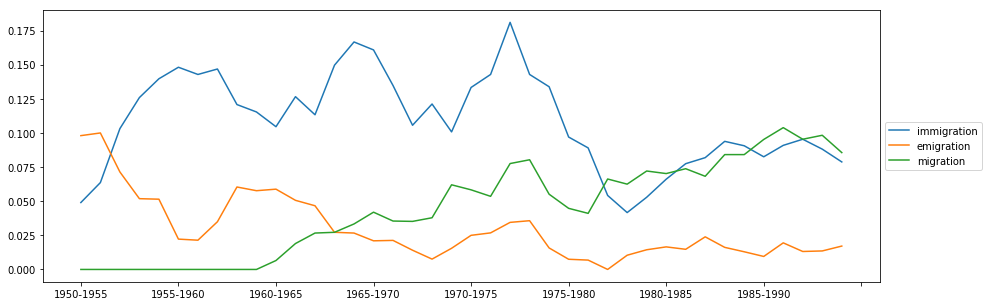

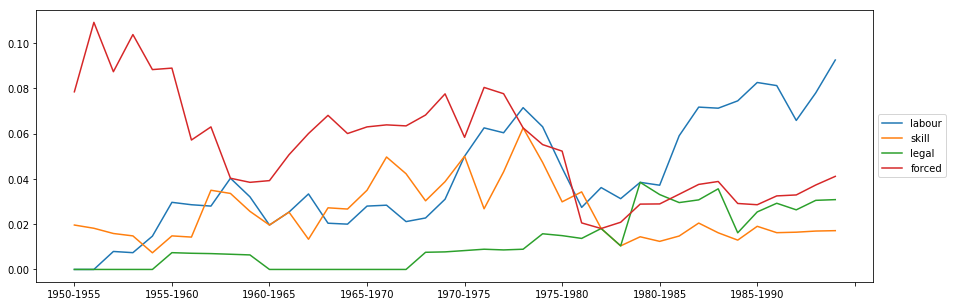

In [123]:
import re

def has_topic(title, topic_words):
    for topic_word in topic_words:
        if re.search(r'\b' + topic_word, title.lower()):
        #if topic_word in title.lower():
            return 1
    return 0

def select_df_by_topic(df, topic_words, topic):
    return df[df.article_title.apply(lambda x: has_topic(x, topic_words[topic])) == 1]

def slide_decade(df, window_size: int = 10):
    num_pubs = []
    periods = []
    for start_year in range(1950, 1990):
        end_year = start_year + window_size
        periods.append(f"{start_year}-{end_year}")
        num_pubs.append(len(df[(df.issue_pub_year >= start_year) & (df.issue_pub_year < end_year)]))
    return num_pubs


def get_topics_df(df, topic_words, window_size: int = 10):
    data = {}
    for topic in topic_words:
        topic_df = select_df_by_topic(df, topic_words, topic)
        data[topic] = slide_decade(topic_df, window_size)

    periods = []
    for start_year in range(1950, 1990):
        end_year = start_year + window_size
        periods.append(f"{start_year}-{end_year}")

    data['total'] = slide_decade(df)
    
    topics_df = pd.DataFrame(data, index=periods)
    
    for topic in topics_df.columns:
        topics_df[topic] = topics_df[topic] / topics_df['total']
        
    return topics_df

# Set the sliding window size
window_size = 5


selected_topic_words = {}
selected_topics = ['cause_effect', 'process', 'decision making']
for topic in selected_topics:
    selected_topic_words[topic] = topic_words[topic]

df_remp_im = df[df.dataset == 'REMP_IM']
topics_df = get_topics_df(df_remp_im, selected_topic_words, window_size)
topics_df.drop('total', axis=1).plot(figsize=(15,5)).legend(loc='center left',bbox_to_anchor=(1.0, 0.5))

selected_topic_words = {}
selected_topics = ['immigration', 'emigration', 'migration']
for topic in selected_topics:
    selected_topic_words[topic] = topic_words[topic]

topics_df = get_topics_df(df_remp_im, selected_topic_words, window_size)
topics_df.drop('total', axis=1).plot(figsize=(15,5)).legend(loc='center left',bbox_to_anchor=(1.0, 0.5))

selected_topic_words = {}
selected_topics = ['labour', 'skill', 'legal', 'forced']
for topic in selected_topics:
    selected_topic_words[topic] = topic_words[topic]

topics_df = get_topics_df(df_remp_im, selected_topic_words, window_size)
topics_df.drop('total', axis=1).plot(figsize=(15,5)).legend(loc='center left',bbox_to_anchor=(1.0, 0.5))


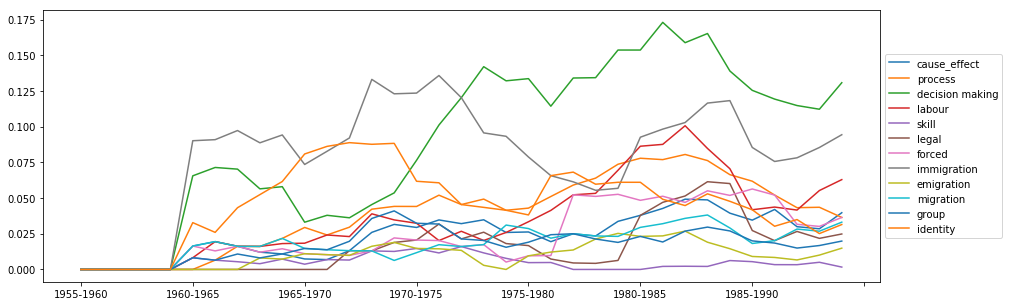

In [124]:
df_imr_research = df[df.dataset == 'IMR_research']
topics_df = get_topics_df(df_imr_research, topic_words, window_size)


topics_df.drop('total', axis=1).plot(figsize=(15,5)).legend(loc='center left',bbox_to_anchor=(1.0, 0.5))

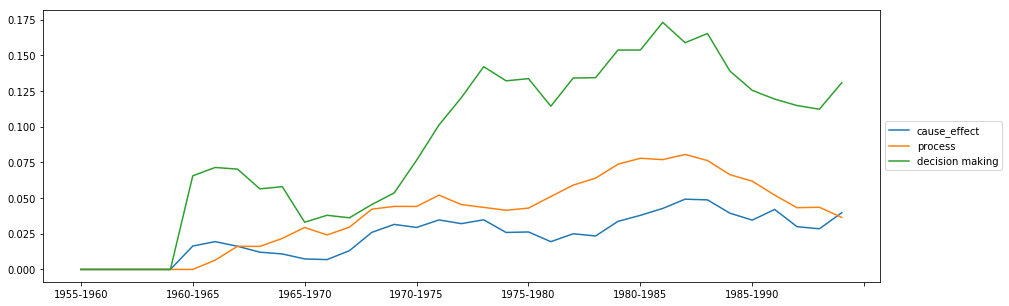

In [125]:
selected_topic_words = {}
selected_topics = ['cause_effect', 'process', 'decision making']
for topic in selected_topics:
    selected_topic_words[topic] = topic_words[topic]

topics_df = get_topics_df(df_imr_research, selected_topic_words, window_size)
topics_df.drop('total', axis=1).plot(figsize=(15,5)).legend(loc='center left',bbox_to_anchor=(1.0, 0.5))



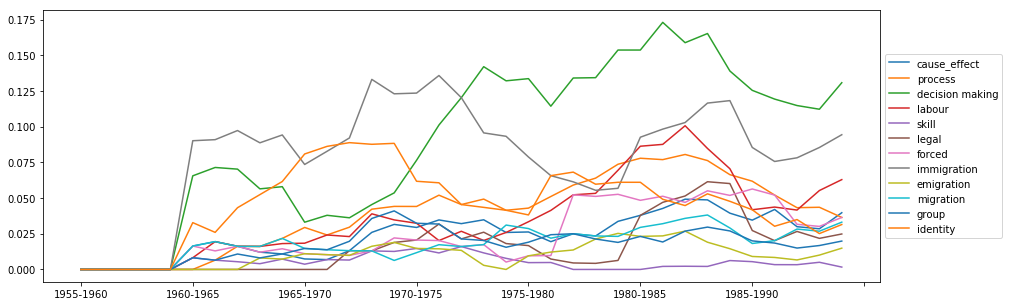

In [126]:
topics_df = get_topics_df(df_imr_research, topic_words, window_size)


topics_df.drop('total', axis=1).plot(figsize=(15,5)).legend(loc='center left',bbox_to_anchor=(1.0, 0.5))

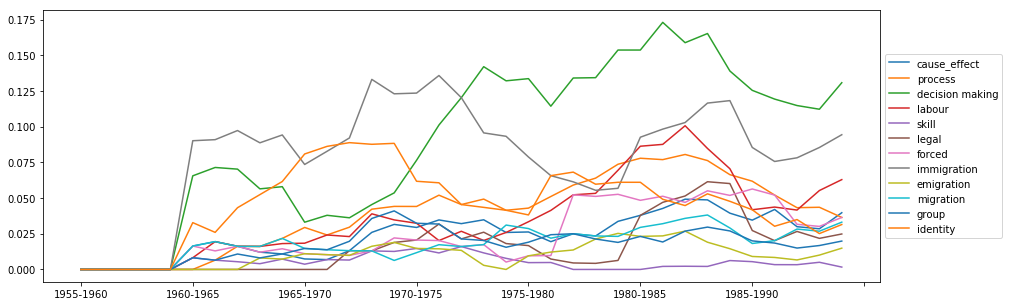

In [127]:
topics_df = get_topics_df(df_imr_research, topic_words, window_size)


topics_df.drop('total', axis=1).plot(figsize=(15,5)).legend(loc='center left',bbox_to_anchor=(1.0, 0.5))

### Observations

- The number of publications increases over time. For many topics, the relative proportion of articles that cover a specific topic drops. This may be a signal that the diversity of topics increases, or that terminology diversifies.



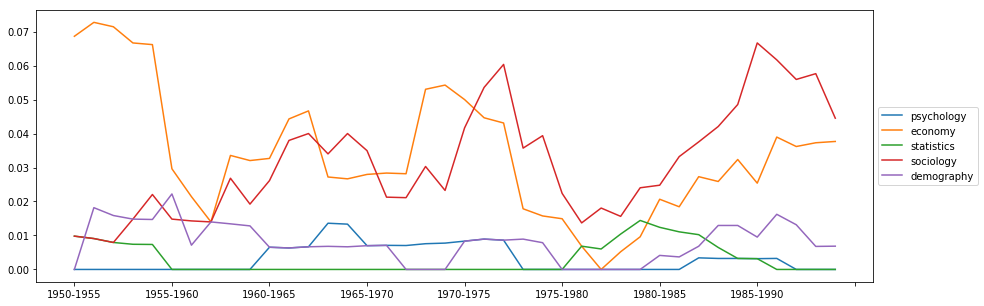

In [128]:
topics_df = get_topics_df(df_remp_im, discipline_words, window_size)
topics_df.drop('total', axis=1).plot(figsize=(15,5)).legend(loc='center left',bbox_to_anchor=(1.0, 0.5))

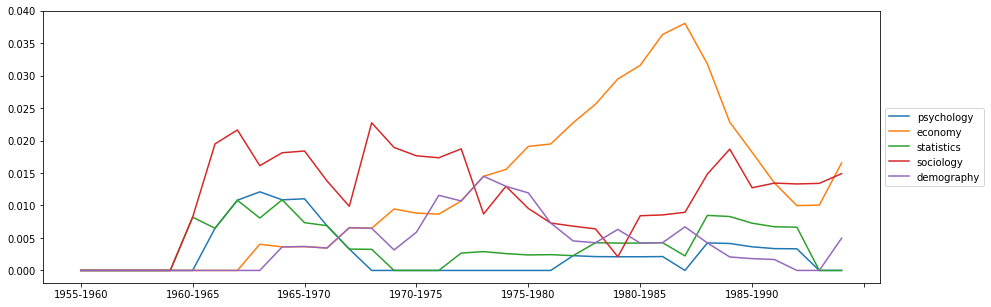

In [129]:
topics_df = get_topics_df(df_imr_research, discipline_words, window_size)
topics_df.drop('total', axis=1).plot(figsize=(15,5)).legend(loc='center left',bbox_to_anchor=(1.0, 0.5))

In [130]:
classified_terms = {}
classified_terms['migration'] = {
            'migration':['migratory', 'migrant', 'migrations','migrants', 'migración', 'migrantes',
                        'migratoria', 'migraciones','migracion', 'migraciín','migrante', 'migracidn','migrationsverhalten',
                       'arbeitsmigranten', 'migratori', 'migrazioni','migratoire', 'migrações', ],
           'integration':['assimilation','integration','adaptation','absorption', 'naturalization','legalization',],
           'emigration':['emigrants', 'emigrant', 'emigracion', 'emigración','emigrazione', 'emigrati','emigração',
                        'emigratión',  'emigranti', 'lémigration', 'émigration','emigrate',],
           'immigration':['immigrants','immigrant','inmigrant', 'immigración', 'immigrazione', 'immigrantes',
                       'inmigrantes', 'inmigration', 'iimmigrants','inmigracion','inmigración','inmigrante', 'immigrate',
                          'immigrati',],
           'remigration':['remigration', 'transmigration', 'transmigrant','reemigracja','euromigration','postmigration','repatriation']}
classified_terms['disciplines'] = {
                    'sociology':['sociology', 'sociological', 'sociologique', 'sociologica',  'sociologia', 'sociolinguistics'],
                    'statistics':['statistics','statistical'],
                    'methods':['methodological','methodologique', 'metodologica','typology','topics','characteristics'],
                    'psychology':['psychological','psychology'],
                    'politics':['politics','political'],
                    'anthropology':['ethnological', 'anthropology','anthropological',],
                    'other':['ecology','ecological','ideology','ideological','mythology','demythologizing',
                            'technology', 'epidemiology', 'tecnologia', 'technological','biological','cosmology', 'chronology', 'ideologies',
                            'economics','ethnics','electronics','ethics']}


In [131]:
temp_df = df[df.normalised_title.str.contains('latin')][['dataset', 'issue_decade']]
s = temp_df.groupby(['dataset', 'issue_decade']).size()

s.unstack('dataset')


dataset,IMR_research,IMR_review,REMP_IM
issue_decade,,,
1960,NaN,4.0,10.0
1970,7.0,8.0,1.0
1980,2.0,11.0,2.0
1990,3.0,10.0,2.0


In [137]:
df.author_surname_initial.value_counts()

                448
Beyer, G         24
Tomasi, S        24
Appleyard, R     21
Brown, M         20
               ... 
Bonnett, A        1
Murphy, H         1
Lazerwitz, B      1
Arafat, I         1
Lean, L           1
Name: author_surname_initial, Length: 2188, dtype: int64

In [147]:
g

author_surname_initial  dataset     
Abadan-Unat, N          IMR_research    4
                        IMR_review      1
Abalos, D               IMR_review      1
Abandan-Unat, N         IMR_research    1
Abell, N                IMR_research    1
                                       ..
Zubrzycki, P            REMP_IM         1
Zucchi, J               IMR_review      1
Zucker, N               IMR_review      1
Zárate, A               IMR_research    1
Ávila, F                REMP_IM         1
Name: dataset, Length: 2479, dtype: int64

In [155]:
g = df.loc[df.author_surname_initial!=''].groupby(['author_surname_initial', 'dataset']).dataset.count()
df_overlap = g.unstack('dataset').fillna(0.0)
print('number of authors with at least one article in both journals:', 
      len(df_overlap[(df_overlap.REMP_IM > 0) & (df_overlap.IMR_research > 0)]))

overlappers = df_overlap[(df_overlap.REMP_IM > 0) & (df_overlap.IMR_research > 0)]
overlappers

number of authors with at least one article in both journals: 77


dataset,IMR_research,IMR_review,REMP_IM
author_surname_initial,,,
"Adepoju, A",1.0,0.0,5.0
"Appleyard, R",1.0,0.0,20.0
"Arnold, F",1.0,1.0,1.0
"Athukorala, P",1.0,0.0,2.0
"Beenstock, M",1.0,0.0,2.0
...,...,...,...
"Wong, L",1.0,0.0,1.0
"Yeoh, B",1.0,0.0,1.0
"Young, C",1.0,0.0,1.0


In [156]:
df_overlap[(df_overlap.REMP_IM > 5)]

dataset,IMR_research,IMR_review,REMP_IM
author_surname_initial,,,
"Appleyard, R",1.0,0.0,20.0
"Bernard, W",2.0,4.0,7.0
"Beyer, G",1.0,2.0,21.0
"Dumon, W",0.0,0.0,8.0
"Johnston, R",0.0,0.0,8.0
"Moncarz, R",1.0,0.0,6.0
"Papademetriou, D",1.0,3.0,7.0
"Samuel, T",1.0,6.0,7.0
"Zubrzycki, J",3.0,0.0,8.0


In [254]:
remp_count=df.loc[(df.author_surname_initial!='')&(df.dataset=="REMP_IM") ]

In [255]:
remp_count.columns

Index(['article_title', 'article_author', 'article_author_index_name',
       'issue_pub_year', 'publisher', 'article_type', 'author_surname_initial',
       'issue_pub_decade', 'dataset', 'issue_decade', 'normalised_title',
       'cause_effect', 'process', 'decision making', 'labour', 'skill',
       'legal', 'forced', 'immigration', 'emigration', 'migration', 'group',
       'identity', 'country', 'continent'],
      dtype='object')

In [256]:
remp_authors = remp_count.groupby(['author_surname_initial']).agg('count')

In [296]:
remp_freq_authors = remp_authors.loc[remp_authors.article_title>5]['article_title']
print(f"{len(remp_freq_authors)} authors have more than 5 publications in REMP_IM")
remp_freq_authors

9 authors have more than 5 publications in REMP_IM


author_surname_initial
Appleyard, R        20
Bernard, W           7
Beyer, G            21
Dumon, W             8
Johnston, R          8
Moncarz, R           6
Papademetriou, D     7
Samuel, T            7
Zubrzycki, J         8
Name: article_title, dtype: int64

In [297]:
fa = list(remp_freq_authors.index)
fra_articles_remp = remp_count.loc[df.author_surname_initial.isin(fa)]

In [298]:
fra_articles_remp.normalised_title

2      some aspect of migration problem in the nether...
15     the assimilation myth a study of second genera...
34     racism a worldwide factor oppose migrant adjus...
46     quelques remarques sur la situation demographi...
50     social and economic integration of alien in fr...
                             ...                        
870    the australian character in the eye of polish ...
871               immigrant search for cultural identity
876                          cuban lawyer ten year later
879    refugee asylum in the united states how the la...
893    immigrant participation in an australian commu...
Name: normalised_title, Length: 92, dtype: object

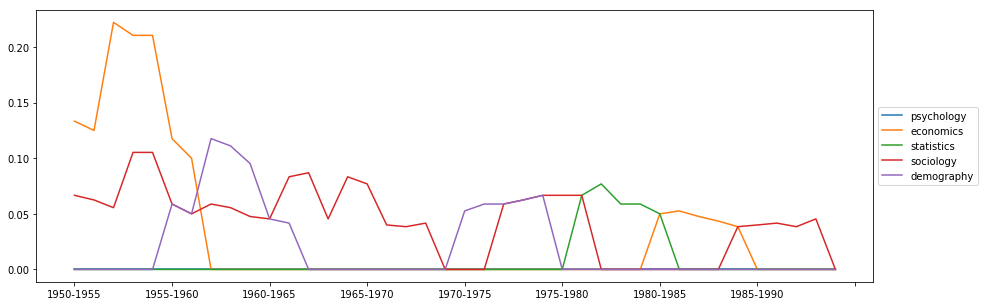

In [299]:
r_topics_df = get_topics_df(fra_articles_remp, discipline_words, window_size)
r_topics_df.drop('total', axis=1).plot(figsize=(15,5)).legend(loc='center left',bbox_to_anchor=(1.0, 0.5))

Text(0.5, 1.0, 'REMP total')

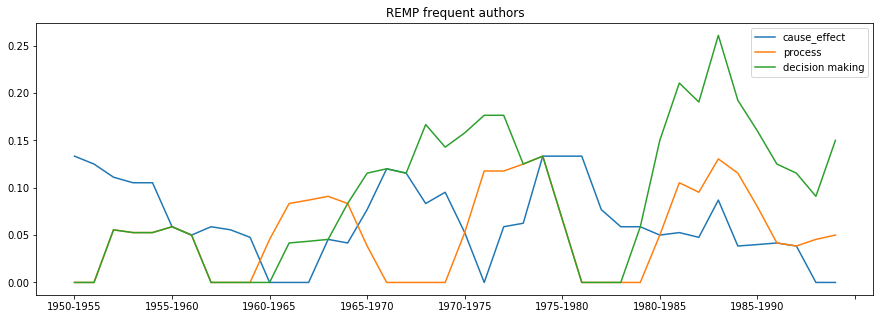

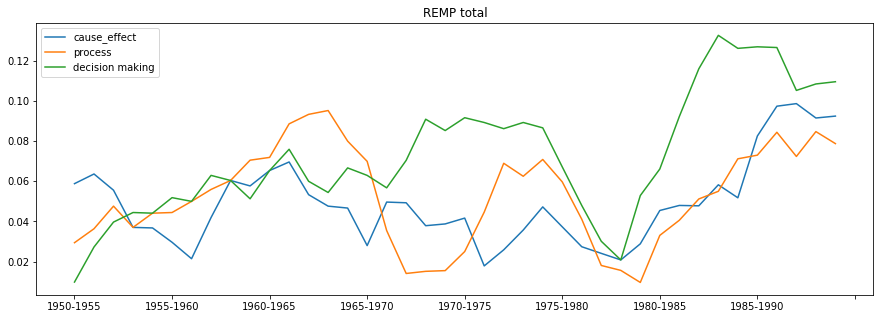

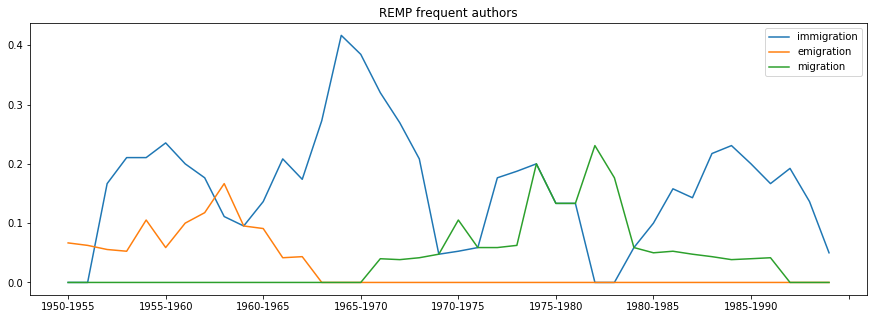

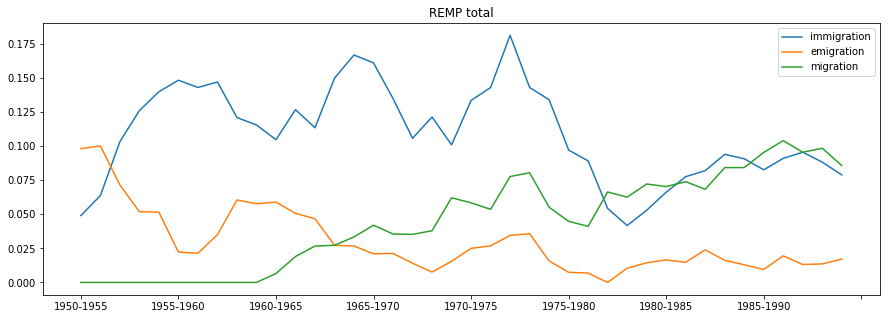

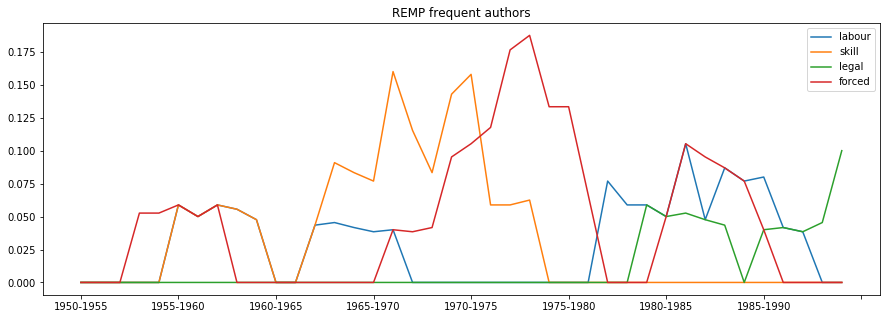

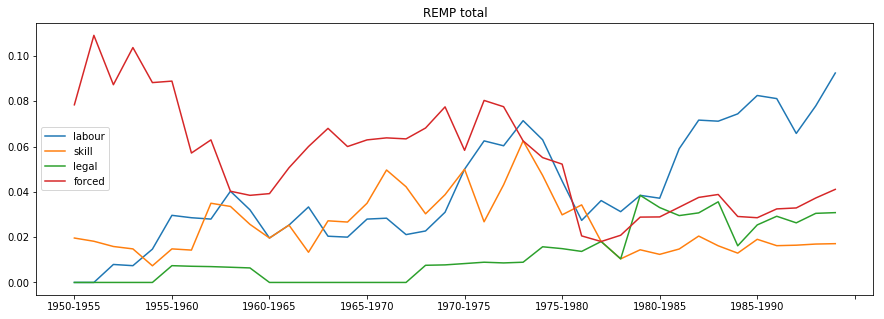

In [300]:
import re

def has_topic(title, topic_words):
    for topic_word in topic_words:
        if re.search(r'\b' + topic_word, title.lower()):
        #if topic_word in title.lower():
            return 1
    return 0

def select_df_by_topic(df, topic_words, topic):
    return df[df.article_title.apply(lambda x: has_topic(x, topic_words[topic])) == 1]

def slide_decade(df, window_size: int = 10):
    num_pubs = []
    periods = []
    for start_year in range(1950, 1990):
        end_year = start_year + window_size
        periods.append(f"{start_year}-{end_year}")
        num_pubs.append(len(df[(df.issue_pub_year >= start_year) & (df.issue_pub_year < end_year)]))
    return num_pubs


def get_topics_df(df, topic_words, window_size: int = 10):
    data = {}
    for topic in topic_words:
        topic_df = select_df_by_topic(df, topic_words, topic)
        data[topic] = slide_decade(topic_df, window_size)

    periods = []
    for start_year in range(1950, 1990):
        end_year = start_year + window_size
        periods.append(f"{start_year}-{end_year}")

    data['total'] = slide_decade(df)
    
    topics_df = pd.DataFrame(data, index=periods)
    
    for topic in topics_df.columns:
        topics_df[topic] = topics_df[topic] / topics_df['total']
        
    return topics_df

# Set the sliding window size
window_size = 5


selected_topic_words = {}
selected_topics = ['cause_effect', 'process', 'decision making']
for topic in selected_topics:
    selected_topic_words[topic] = topic_words[topic]

# we declare two different data sets for comparison: 
# - df_far is the dataset with frequently publishing authors
# - df_remp_in is the dataset of the whole of remp_im
    
df_far = fra_articles_remp
df_remp_im = df[df.dataset == 'REMP_IM']
topics_far_df = get_topics_df(df_far, selected_topic_words, window_size)
aut_title = "REMP frequent authors"
topics_far_df.drop('total', axis=1).plot(figsize=(15,5)).set_title(aut_title)


topics_df = get_topics_df(df_remp_im, selected_topic_words, window_size)
remp_title = "REMP total"
topics_df.drop('total', axis=1).plot(figsize=(15,5)).set_title(remp_title)



selected_topic_words = {}
selected_topics = ['immigration', 'emigration', 'migration']
for topic in selected_topics:
    selected_topic_words[topic] = topic_words[topic]

topics_far_df = get_topics_df(df_far, selected_topic_words, window_size)
aut_title = "REMP frequent authors"
topics_far_df.drop('total', axis=1).plot(figsize=(15,5)).set_title(aut_title)


topics_df = get_topics_df(df_remp_im, selected_topic_words, window_size)
remp_title = "REMP total"
topics_df.drop('total', axis=1).plot(figsize=(15,5)).set_title(remp_title)


selected_topic_words = {}
selected_topics = ['labour', 'skill', 'legal', 'forced']
for topic in selected_topics:
    selected_topic_words[topic] = topic_words[topic]

topics_far_df = get_topics_df(df_far, selected_topic_words, window_size)
aut_title = "REMP frequent authors"
topics_far_df.drop('total', axis=1).plot(figsize=(15,5)).set_title(aut_title)

    
topics_df = get_topics_df(df_remp_im, selected_topic_words, window_size)
remp_title = "REMP total"
topics_df.drop('total', axis=1).plot(figsize=(15,5)).set_title(remp_title)



In [301]:
df_remp_im.columns

Index(['article_title', 'article_author', 'article_author_index_name',
       'issue_pub_year', 'publisher', 'article_type', 'author_surname_initial',
       'issue_pub_decade', 'dataset', 'issue_decade', 'normalised_title',
       'cause_effect', 'process', 'decision making', 'labour', 'skill',
       'legal', 'forced', 'immigration', 'emigration', 'migration', 'group',
       'identity', 'country', 'continent'],
      dtype='object')

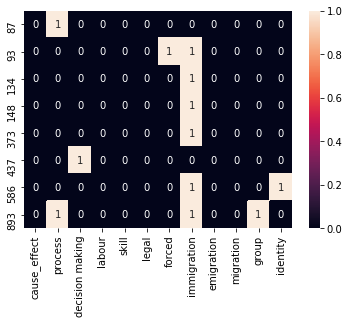

In [302]:
import seaborn as sns

disp_df = sns.heatmap(aut_tit[['cause_effect', 'process', 'decision making', 'labour', 'skill',
       'legal', 'forced', 'immigration', 'emigration', 'migration', 'group',
       'identity']], annot=True)

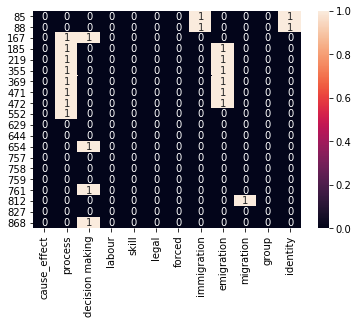

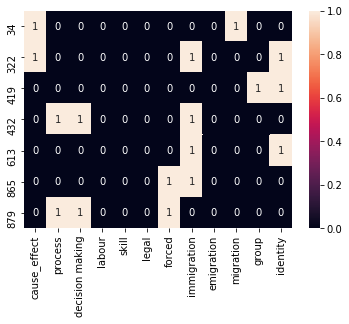

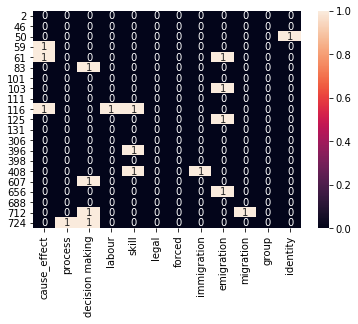

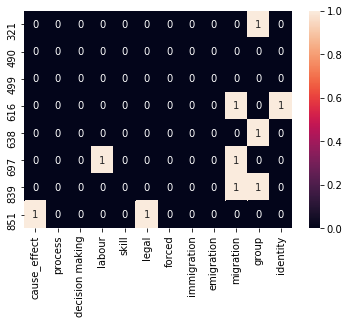

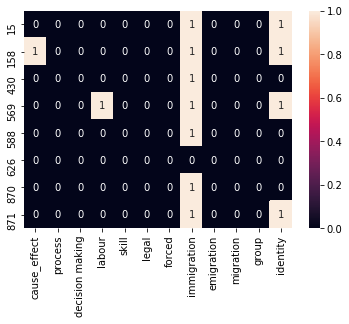

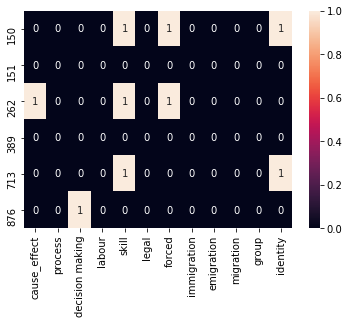

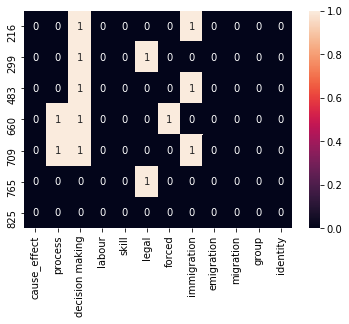

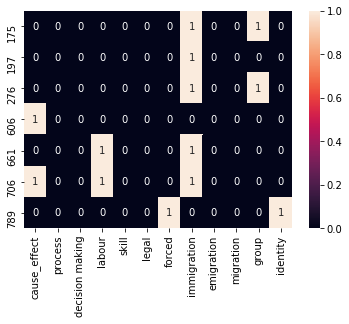

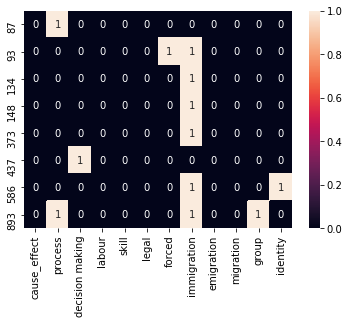

In [303]:
from IPython.core.display import display, HTML
out = HTML()
collst = ['cause_effect', 'process', 'decision making', 'labour', 'skill',
       'legal', 'forced', 'immigration', 'emigration', 'migration', 'group',
       'identity']
for aut in fa:
    aut_tit = df_remp_im.loc[df_remp_im.author_surname_initial==aut]
    
    h_t = aut_tit[collst]
    #out = HTML(f)
    display(HTML(f"<h1>{aut}</h1><br>"))
    hts= sns.heatmap(h_t[['cause_effect', 'process', 'decision making', 'labour', 'skill',
       'legal', 'forced', 'immigration', 'emigration', 'migration', 'group',
       'identity']], annot=True)
    plt.show()


In [304]:
from IPython.core.display import display, HTML
out = HTML()

collst = ['issue_decade','cause_effect', 'process', 'decision making', 'labour', 'skill',
       'legal', 'forced', 'immigration', 'emigration', 'migration', 'group',
       'identity']
for aut in fa:
    aut_tit = df_remp_im.loc[df_remp_im.author_surname_initial==aut]
    h_t = aut_tit[collst].style.background_gradient(cmap='Blues', subset=collst)
    #out = HTML(f)
    display(HTML(f"<h1>{aut}</h1><br>"))
    display(h_t)

,issue_decade,cause_effect,process,decision making,labour,skill,legal,forced,immigration,emigration,migration,group,identity
85,1950,0,0,0,0,0,0,0,1,0,0,0,1
88,1950,0,0,0,0,0,0,0,1,0,0,0,1
167,1980,0,1,1,0,0,0,0,0,0,0,0,0
185,1990,0,1,0,0,0,0,0,0,1,0,0,0
219,1990,0,1,0,0,0,0,0,0,1,0,0,0
355,1990,0,1,0,0,0,0,0,0,1,0,0,0
369,1990,0,1,0,0,0,0,0,0,1,0,0,0
471,1990,0,1,0,0,0,0,0,0,1,0,0,0
472,1990,0,1,0,0,0,0,0,0,1,0,0,0
552,1990,0,1,0,0,0,0,0,0,0,0,0,0


,issue_decade,cause_effect,process,decision making,labour,skill,legal,forced,immigration,emigration,migration,group,identity
34,1970,1,0,0,0,0,0,0,0,0,1,0,0
322,1970,1,0,0,0,0,0,0,1,0,0,0,1
419,1970,0,0,0,0,0,0,0,0,0,0,1,1
432,1960,0,1,1,0,0,0,0,1,0,0,0,0
613,1970,0,0,0,0,0,0,0,1,0,0,0,1
865,1970,0,0,0,0,0,0,1,1,0,0,0,0
879,1970,0,1,1,0,0,0,1,0,0,0,0,0


,issue_decade,cause_effect,process,decision making,labour,skill,legal,forced,immigration,emigration,migration,group,identity
2,1950,0,0,0,0,0,0,0,0,0,0,0,0
46,1950,0,0,0,0,0,0,0,0,0,0,0,0
50,1950,0,0,0,0,0,0,0,0,0,0,0,1
59,1950,1,0,0,0,0,0,0,0,0,0,0,0
61,1950,1,0,0,0,0,0,0,0,1,0,0,0
83,1950,0,0,1,0,0,0,0,0,0,0,0,0
101,1950,0,0,0,0,0,0,0,0,0,0,0,0
103,1950,0,0,0,0,0,0,0,0,1,0,0,0
111,1950,0,0,0,0,0,0,0,0,0,0,0,0
116,1950,1,0,0,1,1,0,0,0,0,0,0,0


,issue_decade,cause_effect,process,decision making,labour,skill,legal,forced,immigration,emigration,migration,group,identity
321,1970,0,0,0,0,0,0,0,0,0,0,1,0
490,1980,0,0,0,0,0,0,0,0,0,0,0,0
499,1970,0,0,0,0,0,0,0,0,0,0,0,0
616,1970,0,0,0,0,0,0,0,0,0,1,0,1
638,1980,0,0,0,0,0,0,0,0,0,0,1,0
697,1980,0,0,0,1,0,0,0,0,0,1,0,0
839,1980,0,0,0,0,0,0,0,0,0,1,1,0
851,1980,1,0,0,0,0,1,0,0,0,0,0,0


,issue_decade,cause_effect,process,decision making,labour,skill,legal,forced,immigration,emigration,migration,group,identity
15,1960,0,0,0,0,0,0,0,1,0,0,0,1
158,1960,1,0,0,0,0,0,0,1,0,0,0,1
430,1960,0,0,0,0,0,0,0,1,0,0,0,0
569,1960,0,0,0,1,0,0,0,1,0,0,0,1
588,1960,0,0,0,0,0,0,0,1,0,0,0,0
626,1960,0,0,0,0,0,0,0,0,0,0,0,0
870,1960,0,0,0,0,0,0,0,1,0,0,0,0
871,1960,0,0,0,0,0,0,0,1,0,0,0,1


,issue_decade,cause_effect,process,decision making,labour,skill,legal,forced,immigration,emigration,migration,group,identity
150,1970,0,0,0,0,1,0,1,0,0,0,0,1
151,1970,0,0,0,0,0,0,0,0,0,0,0,0
262,1970,1,0,0,0,1,0,1,0,0,0,0,0
389,1970,0,0,0,0,0,0,0,0,0,0,0,0
713,1970,0,0,0,0,1,0,0,0,0,0,0,1
876,1970,0,0,1,0,0,0,0,0,0,0,0,0


,issue_decade,cause_effect,process,decision making,labour,skill,legal,forced,immigration,emigration,migration,group,identity
216,1980,0,0,1,0,0,0,0,1,0,0,0,0
299,1980,0,0,1,0,0,1,0,0,0,0,0,0
483,1980,0,0,1,0,0,0,0,1,0,0,0,0
660,1980,0,1,1,0,0,0,1,0,0,0,0,0
709,1980,0,1,1,0,0,0,0,1,0,0,0,0
765,1990,0,0,0,0,0,1,0,0,0,0,0,0
825,1990,0,0,0,0,0,0,0,0,0,0,0,0


,issue_decade,cause_effect,process,decision making,labour,skill,legal,forced,immigration,emigration,migration,group,identity
175,1980,0,0,0,0,0,0,0,1,0,0,1,0
197,1990,0,0,0,0,0,0,0,1,0,0,0,0
276,1980,0,0,0,0,0,0,0,1,0,0,1,0
606,1960,1,0,0,0,0,0,0,0,0,0,0,0
661,1980,0,0,0,1,0,0,0,1,0,0,0,0
706,1980,1,0,0,1,0,0,0,1,0,0,0,0
789,1980,0,0,0,0,0,0,1,0,0,0,0,1


,issue_decade,cause_effect,process,decision making,labour,skill,legal,forced,immigration,emigration,migration,group,identity
87,1950,0,1,0,0,0,0,0,0,0,0,0,0
93,1950,0,0,0,0,0,0,1,1,0,0,0,0
134,1950,0,0,0,0,0,0,0,1,0,0,0,0
148,1960,0,0,0,0,0,0,0,1,0,0,0,0
373,1960,0,0,0,0,0,0,0,1,0,0,0,0
437,1980,0,0,1,0,0,0,0,0,0,0,0,0
586,1960,0,0,0,0,0,0,0,1,0,0,0,1
893,1960,0,1,0,0,0,0,0,1,0,0,1,0


In [1]:
out = HTML('<br/>')

NameError: name 'HTML' is not defined

In [231]:
out.data

'<br/>'